<a href="https://colab.research.google.com/github/samymessal/EEG_octo/blob/full_sleep_multi_label_classification/files/ful_sleep_multilabel_calssification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sleep Spindle Study

## Building Model

In this notebook, we build a model to detect the presence of sleep spindles in the entire EEG recording.
        

In [2]:
!pip install mne
!pip install vmdpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.0 MB/s eta 0:00:00


In [3]:
!git clone -b full_sleep_multi_label_classification https://github.com/samymessal/EEG_octo

Cloning into 'EEG_octo'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 250 (delta 16), reused 39 (delta 8), pack-reused 198
Receiving objects: 100% (250/250), 510.39 MiB | 22.58 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (145/145), done.


In [4]:
import sys
sys.path.append('/content/EEG_octo/files')

import os
cwd = os.getcwd()

print(cwd)
items = os.listdir('/content/EEG_octo/files')

# Print the list of items
for item in items:
    print(item)

/content
feature_extraction.ipynb
plot.py
Starting_kit_ntx_data_challenge_v0_1_Data_Exploration.ipynb
utils.py
untitled.py
building_model.ipynb
data_preparation.ipynb
full_recording_sleep_spindles_classification.ipynb
preprocess.ipynb
ressources
preprocess.py
ful_sleep_multilabel_calssification.ipynb
feature_extraction.py
data_preparation.py



## Imports

We will import the necessary libraries that are needed for processing the data, building the model, and evaluating its performance.
        

In [13]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import json
import data_preparation
import preprocess
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import Callback
import json
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense, BatchNormalization, Flatten
import tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from data_loading import dataset_from_files

### Download data

Using the `processed_data` function from the previous step to download our concatenated raw with its correspondent preprocessing and features.

In [6]:
dataset = dataset_from_files(
    ["/content/EEG_octo/dataset/train_S002_night1_hackathon_raw.mat",
    "/content/EEG_octo/dataset/train_S003_night5_hackathon_raw.mat"
    ],
    ["/content/EEG_octo/dataset/train_S002_labeled.csv",
    "/content/EEG_octo/dataset/train_S003_labeled.csv"
    ],
    target_label="SS1",
    frequency_band=(8, 16),
    window_size=2.5,
    band1=(8, 13),
    band2= (13, 16),
)

Creating RawArray with float64 data, n_channels=1, n_times=4965399
    Range : 0 ... 4965398 =      0.000 ... 19861.592 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: ['0_0', '0_1', '1_0']
Not setting metadata
1191 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1191 events and 626 original time points ...
0 bad epochs dropped
epcohs.get_data().shape: (1191, 1, 6


#### Model

The chosen model is an LSTM, since we are dealing with timeframes, LSTM are known to deal well with time depending samples. A k-cross validation is implemented, partitioning the data into 5 parts and alterning between the 4 parts for training and the 1 for testing.
        

In [7]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        p = self.precision.result()
        r = self.recall.result()
        self.f1_score.assign(2 * ((p * r) / (p + r + tf.keras.backend.epsilon())))

    def result(self):
        return self.f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0)

print("X.shape:", X.shape)
print("labels.shape:", labels.shape)
print("shape before reshaping:", X.shape)
X = X.transpose((0, 2, 1))
print("shape after reshaping:", X.shape)

X.shape: (2241, 1, 626)
labels.shape: (2241, 2)
shape before reshaping: (2241, 1, 626)
shape after reshaping: (2241, 626, 1)


In [11]:
def create_model():
    input_layer = keras.Input(shape=(X.shape[1], X.shape[2]))

    x = Conv1D(
        filters=32, kernel_size=3, strides=1, activation="relu", padding="same"
    )(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(
        filters=64, kernel_size=3, strides=1, activation="relu", padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(
        filters=128, kernel_size=5, strides=1, activation="relu", padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Now you can flatten the output if you haven't applied global pooling before
    x = Flatten()(x)

    x = Dense(
        2048, activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
    )(x)
    x = Dropout(0.2)(x)

    x = Dense(
        1024,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
    )(x)
    x = Dropout(0.2)(x)
    x = Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
    )(x)
    output_layer = Dense(labels.shape[1], activation="sigmoid")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)


train indices: (1494,)
test indices: (747,)
Epoch 1/30
47/47 [==============================] - 17s 126ms/step - loss: 11.6709 - accuracy: 0.5910 - precision_6: 0.2088 - recall_6: 0.1821 - f1_score: 0.1945 - val_loss: 11.6697 - val_accuracy: 0.6961 - val_precision_6: 0.1915 - val_recall_6: 0.0837 - val_f1_score: 0.1165
Epoch 2/30
47/47 [==============================] - 5s 114ms/step - loss: 10.8061 - accuracy: 0.6881 - precision_6: 0.4320 - recall_6: 0.1872 - f1_score: 0.2612 - val_loss: 9.8757 - val_accuracy: 0.7644 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/30
47/47 [==============================] - 5s 110ms/step - loss: 8.6852 - accuracy: 0.7336 - precision_6: 0.6590 - recall_6: 0.2923 - f1_score: 0.4050 - val_loss: 7.7718 - val_accuracy: 0.8179 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/30
47/47 [==============================] - 5s 111ms/step - loss: 6.7079 - accuracy: 0.7028 - prec

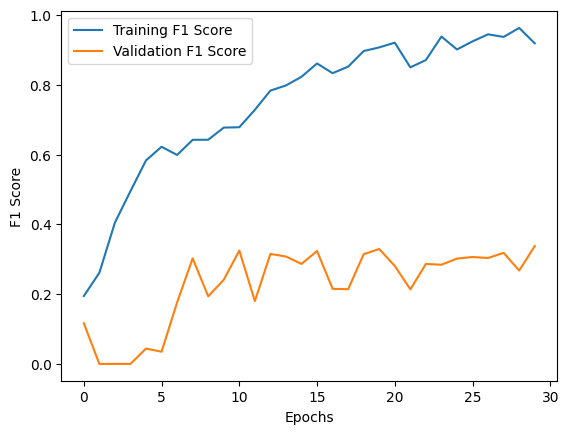

train indices: (1494,)
test indices: (747,)
Epoch 1/30
47/47 [==============================] - 11s 120ms/step - loss: 11.3463 - accuracy: 0.4224 - precision_8: 0.1723 - recall_8: 0.1139 - f1_score: 0.1371 - val_loss: 11.4903 - val_accuracy: 0.1767 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/30
47/47 [==============================] - 5s 113ms/step - loss: 10.3456 - accuracy: 0.4257 - precision_8: 0.3182 - recall_8: 0.0173 - f1_score: 0.0329 - val_loss: 9.2908 - val_accuracy: 0.1673 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/30
47/47 [==============================] - 5s 110ms/step - loss: 7.9363 - accuracy: 0.3568 - precision_8: 0.5652 - recall_8: 0.0322 - f1_score: 0.0609 - val_loss: 6.8525 - val_accuracy: 0.1673 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/30
47/47 [==============================] - 5s 113ms/step - loss: 5.7970 - accuracy: 0

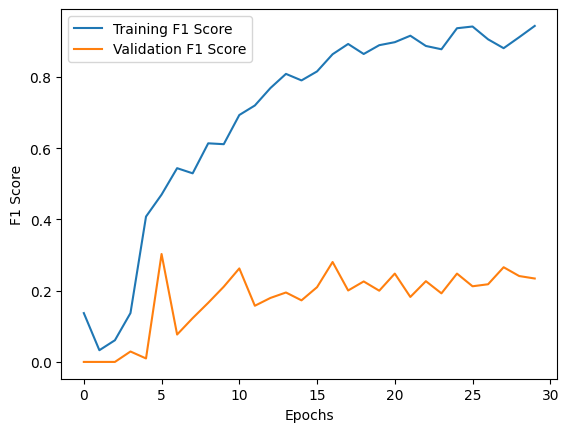

train indices: (1494,)
test indices: (747,)
Epoch 1/30


ResourceExhaustedError: ignored

In [ ]:
# kfold = KFold(n_splits=3, shuffle=True)
# for fold_no, (train, test) in enumerate(kfold.split(X, labels)):
#     print("train indices:", train.shape)
#     print("test indices:", test.shape)
#     # Define the model architecture
#     model = create_model()

#     # Compile the model
#     model.compile(
#         optimizer=keras.optimizers.Adam(),
#         loss="binary_crossentropy",
#         metrics=[
#             'accuracy',
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall(),
#             F1Score(),
#         ]
#     )

#     # Train the model
#     history = model.fit(
#         X[train],
#         labels[train],
#         epochs=30,
#         validation_data=(X[test], labels[test]),
#     )


#     training_f1_scores = history.history['f1_score']
#     validation_f1_scores = history.history['val_f1_score']

#     plt.plot(training_f1_scores, label='Training F1 Score')
#     plt.plot(validation_f1_scores, label='Validation F1 Score')
#     plt.xlabel('Epochs')
#     plt.ylabel('F1 Score')
#     plt.legend()
#     plt.show()

# Define the model architecture
model = create_model()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        F1Score(),
    ]
)

# Train the model
history = model.fit(
    dataset,
    epochs=30
)


training_f1_scores = history.history['f1_score']
validation_f1_scores = history.history['val_f1_score']

plt.plot(training_f1_scores, label='Training F1 Score')
plt.plot(validation_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()